In [1]:
#import packages and define a plotting function
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as colors
from scipy.stats import pearsonr
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

import json
from datetime import datetime

def residue_plot(annotation_df, product_lengths, protein, protein_info_df, feature_height = 0.05, region_height = 0.05, domain_height = 0.05, rasa_height = 0.2, feature_legend_pos = (1.02, 1), title = None, feature_legend_cols = 2, xtick_range = 10):
    
    annotation_df_bar = annotation_df.loc[annotation_df.description == protein].groupby("respos")["count"].sum().rename("count").reset_index()
    
    all_residue_positions = list(range(1, product_lengths.loc[protein]["aa_length"] + 1))
    missing_residue_positions = [res for res in all_residue_positions if res not in annotation_df_bar.respos.unique()]
    missing_residue_positions_df = pd.DataFrame({"respos": missing_residue_positions, "count" : 0})
    
    annotation_df_bar = pd.concat([annotation_df_bar, missing_residue_positions_df])
    annotation_df_bar = annotation_df_bar.sort_values("respos", ascending = True)
    annotation_df_bar["product"] = protein
    max_respos = annotation_df_bar.respos.max()
    mean_count = annotation_df_bar["count"].mean()
    sd_count = annotation_df_bar["count"].std()
    max_count = annotation_df_bar["count"].max()
    
    outlier_positions = annotation_df_bar.loc[annotation_df_bar["count"] >= mean_count + (2*sd_count)].copy()
    outlier_residue_mutations = annotation_df.loc[(annotation_df.description == protein) & (annotation_df.respos.isin(outlier_positions.respos))].groupby(["respos", "altres"]).agg({"count": "sum"}).rename(columns = {"count": "num_samples"}).reset_index().copy()
    outlier_residue_mutations["product"] = protein
    
    shapes = {}
    feature_elements = []
    
    to_plot = 0
    plot_annotation = False
    if isinstance(protein_info_df, pd.DataFrame):
        if protein_info_df.loc[(protein_info_df["product"] == protein) & (protein_info_df["type"] == "feature")].feature.nunique() != 0 :
            to_plot += 1 
            plot_annotation = True
        

    plot_positions = [1.15]
    
    if plot_annotation:
        qualitative_colors = sns.color_palette("Pastel1", protein_info_df.loc[(protein_info_df["product"] == protein) & (protein_info_df["type"] == "feature")].feature.nunique()) 
        positions = [(x, y, z) for x, y, z in zip(protein_info_df.loc[(protein_info_df["product"] == protein) & (protein_info_df["type"] == "feature"), 'start'], protein_info_df.loc[(protein_info_df["product"] == protein) & (protein_info_df["type"] == "feature"), 'end'], protein_info_df.loc[(protein_info_df["product"] == protein) & (protein_info_df["type"] == "feature"), 'feature'])]
        bottom = 1.15 * max_count
        height = feature_height * max_count
        for position in positions:
            left, width, = (position[0], position[1] - position[0])
            rect=mpatches.Rectangle((left,bottom),width,height,alpha=1, facecolor=qualitative_colors[positions.index(position)])
            shapes[position[2]] = rect
            legend_element = Line2D([0], [0], color=qualitative_colors[positions.index(position)], lw=4, label=position[2])
            feature_elements.append(legend_element)
                              
    fig, ax = plt.subplots(figsize = (10,6))
    
    y_axis_title = "# Lineages w/ mutation at position"
    x_axis_title = "Residue Position"
    title = protein

    sns.barplot(data = annotation_df_bar,x = "respos", y = "count")
    
    #leave default if no annotations to plot
    if plot_annotation:
        ax.set_ylim(0, max_count * (1 + to_plot * (0.2)))
        
    plt.xticks(np.append(np.array([0]), np.arange(xtick_range - 1, annotation_df_bar.respos.max() - 1, xtick_range)))
    ax.set_xticklabels(ax.get_xticklabels(), ha='right', rotation=45)
    ax.tick_params(axis='both', which='major', labelsize=8)
    plt.title(title, fontsize = 12)
    plt.xlabel(x_axis_title, fontsize = 8)
    plt.ylabel(y_axis_title, fontsize = 8)
    plt.axhline(y=mean_count + (2*sd_count),linewidth=1, color='red')

    for shape in shapes:
        plt.gca().add_patch(shapes[shape])
    
    if plot_annotation:
        ax.legend(handles=feature_elements, loc='lower center', title = "Feature", fontsize=8, title_fontsize=8, bbox_to_anchor=feature_legend_pos, borderaxespad=0, ncol = feature_legend_cols)
        #ax.add_artist(feature_legend)
    plt.tight_layout()
    #fig.savefig(f'{plot_dir}/{title}_{"unique_" if unique else ""}{"lineage" if lineage_plot else ""}.png', bbox_inches='tight', dpi = 600)
    plt.close()
    return (fig, ax, mean_count, sd_count, max_count, annotation_df_bar, outlier_positions, outlier_residue_mutations)

In [3]:
product_order = [
        'leader protein', 
        'nsp2', 
        'nsp3', 
        'nsp4', 
        '3C-like proteinase', 
        'nsp6', 
        'nsp7', 
        'nsp8', 
        'nsp9', 
        'nsp10', 
        'nsp11', 
        'RNA-dependent RNA polymerase', 
        'helicase', 
        "3'-to-5' exonuclease", 
        'endoRNAse', 
        "2'-O-ribose methyltransferase",
        'surface glycoprotein',
        'ORF3a protein',
        'envelope protein', 
        'membrane glycoprotein',
        'ORF6 protein', 
        'ORF7a protein', 
        'ORF7b', 
        'ORF8 protein',
        'ORF10 protein',
        'nucleocapsid phosphoprotein']

product_lengths = {
    "2'-O-ribose methyltransferase": 298, 
    "3'-to-5' exonuclease": 527,
    "3C-like proteinase": 306,
    "ORF10 protein": 38, 
    "ORF3a protein": 275,
    "ORF6 protein": 61,
    "ORF7a protein": 121, 
    "ORF7b": 43,
    "ORF8 protein": 121,
    "RNA-dependent RNA polymerase": 932,
    "endoRNAse": 346,
    "envelope protein": 75,
    "helicase": 601,
    "leader protein": 180,
    "membrane glycoprotein": 222,
    "nsp10": 139,
    "nsp11": 13,
    "nsp2": 638,
    "nsp3": 1945,
    "nsp4": 500,
    "nsp6": 290,
    "nsp7": 83,
    "nsp8": 198,
    "nsp9": 113,
    "nucleocapsid phosphoprotein": 419,
    "surface glycoprotein": 1273
} #can we import this from spear data pkl maybe

product_lengths = pd.DataFrame.from_dict(product_lengths, orient='index', columns = ["aa_length"])

all_aas = ["A", "R", "N", "D", "C", "E", "Q", "G", "H", "I", "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]

## Section 3.3.2

Add some text here eventually describing notebook purpose.

In [9]:
spear_data_file = "/home/twr_w20032671/miniconda3/envs/spear/data/spear_data.h5"

spear_data = pd.read_hdf(spear_data_file, "bloom_escape_class1")

In [17]:
#the annotation summary for all analysed lineages
lineages_mutations_file = "/raid/MattC/repos/spear_thesis_analysis/representative_lineages_genbank/spear_representative_lineages_genbank/spear_annotation_summary.tsv"
lineages_pangolin_report_file = "/raid/MattC/repos/spear_thesis_analysis/representative_lineages_genbank/spear_representative_lineages_genbank/lineage_report.csv"
spear_data_file = "/home/twr_w20032671/miniconda3/envs/spear/data/spear_data.h5"

In [41]:
#the output directory for figures
analysis_output_dir = "/raid/MattC/repos/spear_thesis_analysis/"

In [18]:
#read in the files
spear_data = pd.read_hdf(spear_data_file, "spear_anno_file")
lineages_mutations = pd.read_csv(lineages_mutations_file, sep = "\t")
lineages_pangolin_report = pd.read_csv(lineages_pangolin_report_file)

In [20]:
#merge pangolin lineages with annotations
lineages_mutations["respos"] = lineages_mutations.residues.str.extract(r"^[A-Z]([\d\.]+)[A-Za-z]+").astype("float")
lineages_mutations = lineages_mutations.merge(lineages_pangolin_report, how = "left", left_on = "sample_id", right_on = "taxon")

In [21]:
lineages_mutations_counts = lineages_mutations.loc[lineages_mutations.consequence_type.isin(["synonymous_variant", "intergenic_region"]) == False].groupby("description").agg(
    {"residues":"value_counts"}).rename(columns = {"residues": "num_lineages"}).sort_values("num_lineages", ascending = False).reset_index()

#add the total protein length
lineages_mutations_counts = lineages_mutations_counts.merge(product_lengths, left_on = "description", right_index = True)

In [22]:
### NOW LOOKING AT STRUCTURAL HOTSPOTS IN NON-SPIKE PROTEINS

In [23]:
#number of unique residue mutations per protein
unique_mutations_per_prot = lineages_mutations_counts.groupby("description").size().rename("num_unique_muts").sort_values(ascending = False).reset_index()#.loc[lineages_mutations_counts.description == "membrane glycoprotein"].head(50)
unique_mutations_per_prot = unique_mutations_per_prot.merge(product_lengths, left_on = "description", right_index = True)

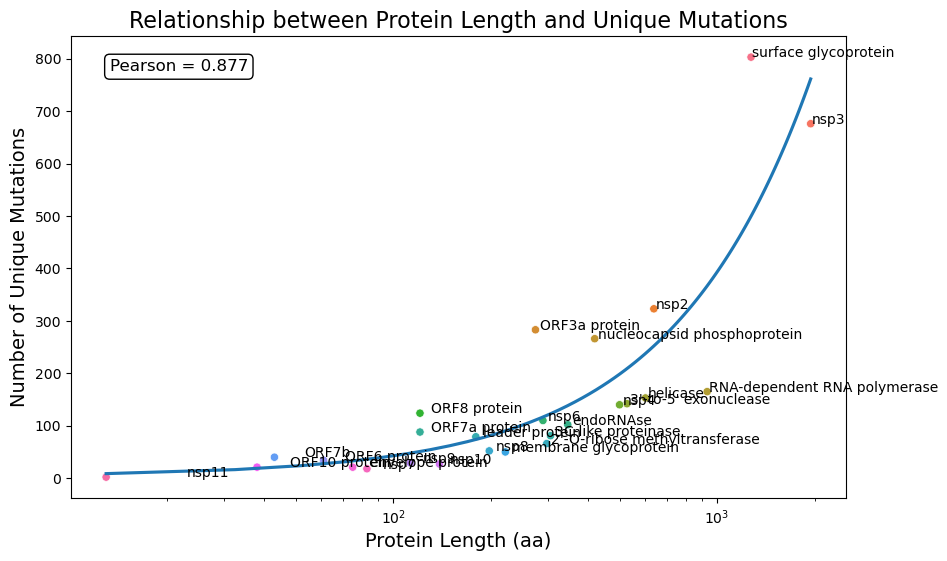

In [26]:
#get mutation rate per aa and the pearson correlation coeff
unique_mutations_per_prot["muts_per_aa"] = unique_mutations_per_prot.num_unique_muts / unique_mutations_per_prot.aa_length
product_mut_size_pearson_corr = unique_mutations_per_prot[["num_unique_muts", "aa_length"]].corr()["num_unique_muts"]["aa_length"]

##add the regplot without scatter
fig, ax = plt.subplots(figsize=(10, 6))
product_mutation_regplot = sns.regplot(
    x="aa_length", 
    y="num_unique_muts", 
    data=unique_mutations_per_prot, 
    scatter = False,
    ci = False
)

##add the scatter plot independently with colouring by protein and no legend - then add the text annotations
sns.scatterplot(x = 'aa_length', y = 'num_unique_muts', data=unique_mutations_per_prot, hue='description', legend = False)
for i, row in unique_mutations_per_prot.iterrows():
    ax.text(row['aa_length']+10, row['num_unique_muts'], str(row['description']))
    #need to only highlight certiin 

#convert scales to logs
product_mutation_regplot.set(xscale="log")

#add the pearson corr coeff to the plot
plt.annotate(
    f'Pearson = {round(product_mut_size_pearson_corr, 3)}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    ha='left',
    va='top',
    bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white')
)

#format axis and titles
plt.title("Relationship between Protein Length and Unique Mutations", fontsize=16)
plt.xlabel("Protein Length (aa)", fontsize=14)
plt.ylabel("Number of Unique Mutations", fontsize=14)

plt.savefig(f"{analysis_output_dir}/figures/lineage_analysis/protein_length_unique_mutations.svg")
plt.savefig(f"{analysis_output_dir}/figures/lineage_analysis/protein_length_unique_mutations.png")

In [28]:
lineages_mutations["compound"] = lineages_mutations["description"] + lineages_mutations["residues"]
lineages_mutations["compound_nt"] = lineages_mutations.POS.astype("str") + lineages_mutations.REF + lineages_mutations.ALT
lineages_mutations["respos"] = lineages_mutations["residues"].str.extract(r'[A-Z\*]-*([0-9]+)-*[a-zA-Z\*\?]+').astype("float64")
lineages_mutations["refres"] = lineages_mutations["residues"].str.extract(r'([A-Z\*])-*[0-9]+-*[a-zA-Z\*\?]+').astype("str")
lineages_mutations["altres"] = lineages_mutations["residues"].str.extract(r'[A-Z\*]-*[0-9]+-*([a-zA-Z\*\?]+)').astype("str")


lineages_mutations_respos_counts = lineages_mutations.loc[lineages_mutations.consequence_type.isin(["synonymous_variant", "intergenic_region"]) == False].groupby(["description", "respos", "altres"]).agg({"sample_id": "nunique"}).rename(columns = {"sample_id": "count"}).reset_index()

In [31]:
# List of proteins
proteins = {'surface glycoprotein' : {"product": 'surface glycoprotein', "xtick_range": 100, "feature_legend_cols": 4, "feature_legend_pos": (0.5, -0.5), "columns_to_combine" : ["region", "domain"]}, 
            'nucleocapsid phosphoprotein': {"product": 'nucleocapsid phosphoprotein', "xtick_range": 10, "feature_legend_cols": 2, "feature_legend_pos": (0.5, -0.45), "columns_to_combine" : ["region", "domain", "feature"]},  
            'membrane glycoprotein': {"product": 'membrane glycoprotein', "xtick_range": 10, "feature_legend_cols": 3, "feature_legend_pos": (0.5, -0.5), "columns_to_combine" : ["region", "domain"]}, 
            'leader protein': {"product": 'leader protein', "xtick_range": 10, "feature_legend_cols": 2, "feature_legend_pos": (0.5, -0.45), "columns_to_combine" : ["region", "domain", "feature"]}, 
            'envelope protein': {"product": 'envelope protein', "xtick_range": 10, "feature_legend_cols": 2, "feature_legend_pos": (0.5, -0.45), "columns_to_combine" : ["region", "domain", "feature"]}, 
            'nsp2': {"product": 'nsp2', "xtick_range": 10, "feature_legend_cols": 2, "feature_legend_pos": (0.5, -0.45), "columns_to_combine" : ["region", "domain", "feature"]}, 
            'nsp3': {"product": 'nsp3', "xtick_range": 10, "feature_legend_cols": 2, "feature_legend_pos": (0.5, -0.45), "columns_to_combine" : ["region", "domain", "feature"]}, 
            'nsp4': {"product": 'nsp4', "xtick_range": 10, "feature_legend_cols": 2, "feature_legend_pos": (0.5, -0.45), "columns_to_combine" : ["region", "domain", "feature"]}, 
            '3C-like proteinase': {"product": '3C-like proteinase', "xtick_range": 10, "feature_legend_cols": 2, "feature_legend_pos": (0.5, -0.45), "columns_to_combine" : ["region", "domain", "feature"]}, 
            'nsp7': {"product": 'nsp7', "xtick_range": 10, "feature_legend_cols": 2, "feature_legend_pos": (0.5, -0.45), "columns_to_combine" : ["region", "domain", "feature"]}, 
            'nsp8': {"product": 'nsp8', "xtick_range": 10, "feature_legend_cols": 2, "feature_legend_pos": (0.5, -0.45), "columns_to_combine" : ["region", "domain", "feature"]}, 
            'nsp9': {"product": 'nsp9', "xtick_range": 10, "feature_legend_cols": 2, "feature_legend_pos": (0.5, -0.45), "columns_to_combine" : ["region", "domain", "feature"]}, 
            'nsp10': {"product": 'nsp10', "xtick_range": 10, "feature_legend_cols": 2, "feature_legend_pos": (0.5, -0.45), "columns_to_combine" : ["region", "domain", "feature"]}, 
            'RNA-dependent RNA polymerase': {"product": 'RNA-dependent RNA polymerase', "xtick_range": 10, "feature_legend_cols": 2, "feature_legend_pos": (0.5, -0.45), "columns_to_combine" : ["region", "domain", "feature"]}, 
            'helicase': {"product": 'helicase', "xtick_range": 10, "feature_legend_cols": 2, "feature_legend_pos": (0.5, -0.45), "columns_to_combine" : ["region", "domain", "feature"]}, 
            "3'-to-5' exonuclease": {"product": "'3'-to-5' exonuclease", "xtick_range": 10, "feature_legend_cols": 2, "feature_legend_pos": (0.5, -0.45), "columns_to_combine" : ["region", "domain", "feature"]}, 
            'endoRNAse': {"product": 'endoRNAse', "xtick_range": 10, "feature_legend_cols": 2, "feature_legend_pos": (0.5, -0.45), "columns_to_combine" : ["region", "domain", "feature"]}, 
            "2'-O-ribose methyltransferase": {"product": "2'-O-ribose methyltransferase", "xtick_range": 10, "feature_legend_cols": 2, "feature_legend_pos": (0.5, -0.45), "columns_to_combine" : ["region", "domain", "feature"]}, 
            'ORF3a protein': {"product": 'ORF3a protein', "xtick_range": 10, "feature_legend_cols": 2, "feature_legend_pos": (0.5, -0.45), "columns_to_combine" : ["region", "domain", "feature"]}, 
            'ORF7a protein': {"product": 'ORF7a protein', "xtick_range": 10, "feature_legend_cols": 2, "feature_legend_pos": (0.5, -0.45), "columns_to_combine" : ["region", "domain"]}, 
            'ORF8 protein': {"product": 'ORF8 protein', "xtick_range": 10, "feature_legend_cols": 2, "feature_legend_pos": (0.5, -0.45), "columns_to_combine" : ["region", "domain", "feature"]}}

# Dictionary to store results
plots = {}

# Loop through each protein
for protein, params in proteins.items():
    spear_data_filtered = spear_data.loc[spear_data["product"] == protein].copy()
    if not spear_data_filtered.empty:
        spear_data_filtered["annotation_compound"] = spear_data_filtered[params["columns_to_combine"]].apply(lambda row: ' '.join(row.values.astype(str)), axis=1).str.strip()
        spear_data_filtered = spear_data_filtered.loc[spear_data_filtered["annotation_compound"] != ""]

        bar_annos = spear_data_filtered.groupby(["product", "annotation_compound"]).agg(
            start=("AA_coordinate", "min"),
            end=("AA_coordinate", "max")
        ).sort_values("start", ascending=True).reset_index().rename(columns={"annotation_compound": "feature"})

        bar_annos["product"] = bar_annos["product"].astype("category").cat.set_categories(product_order, ordered=True)
        bar_annos["type"] = "feature"
    else:
        bar_annos = None
    
    overview_lineage_out = residue_plot(lineages_mutations_respos_counts, product_lengths, protein, bar_annos, 
                                        feature_legend_pos=params["feature_legend_pos"], feature_legend_cols=params["feature_legend_cols"], xtick_range=params["xtick_range"])
    
    plot, ax, mean_count, sd_count, max_count, overview_lineage_table, overview_lineage_outlier_positions, overview_lineage_residue_mutations = overview_lineage_out
    plot.savefig(f'{analysis_output_dir}/figures/lineage_analysis/product_plots/{protein.replace(" ", "_")}.svg')
    plot.savefig(f'{analysis_output_dir}/figures/lineage_analysis/product_plots/{protein.replace(" ", "_")}.png')
    # Store the plot and other results in the dictionary
    plots[protein] = {
        "protein": protein,
        "plot": plot,
        "ax": ax,
        "table": overview_lineage_table,
        "mean_mutation_freq" : mean_count,
        "sd_mutation_freq" : sd_count,
        "max_mutation_freq" : max_count,
        "residue_table": overview_lineage_table,
        "outlier_positions": overview_lineage_outlier_positions,
        "residue_mutations": overview_lineage_residue_mutations
    }

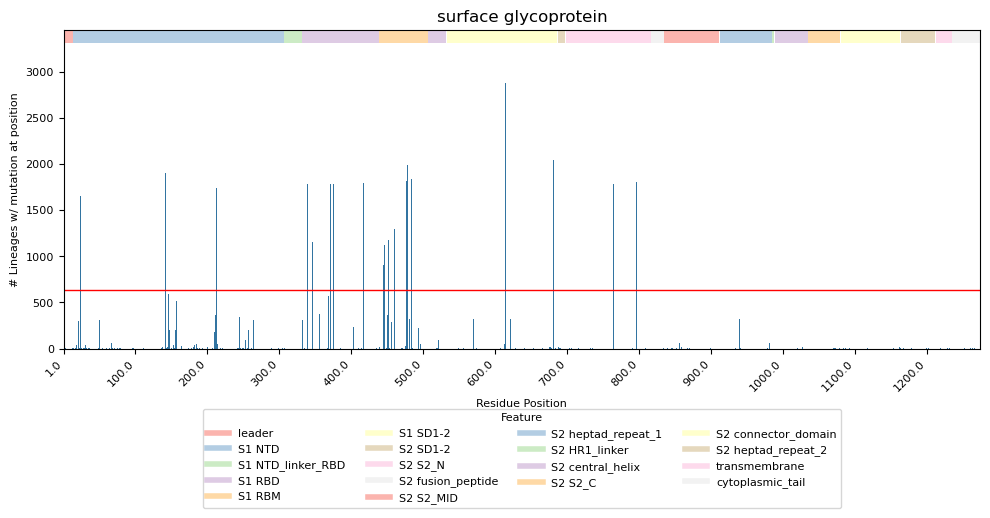

In [32]:
plots["surface glycoprotein"]["plot"]

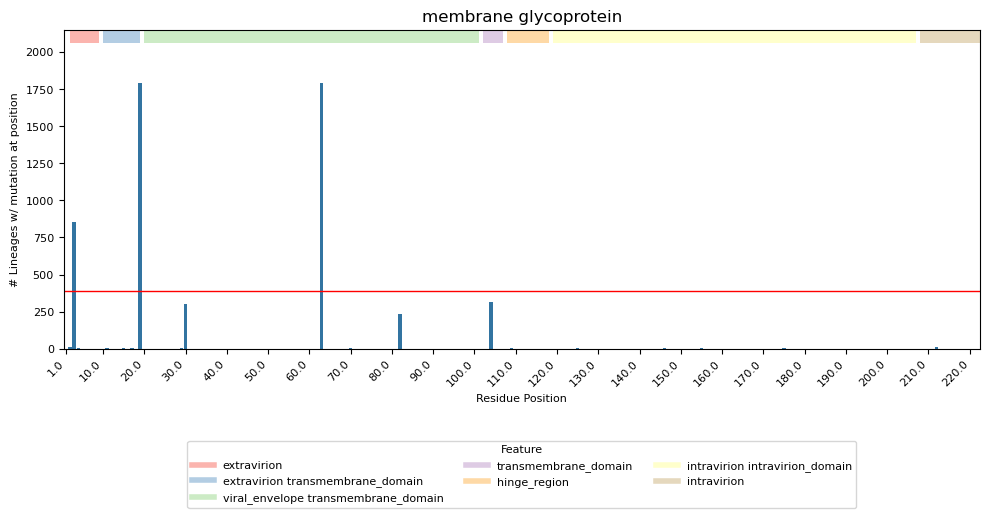

In [33]:
plots["membrane glycoprotein"]["plot"]

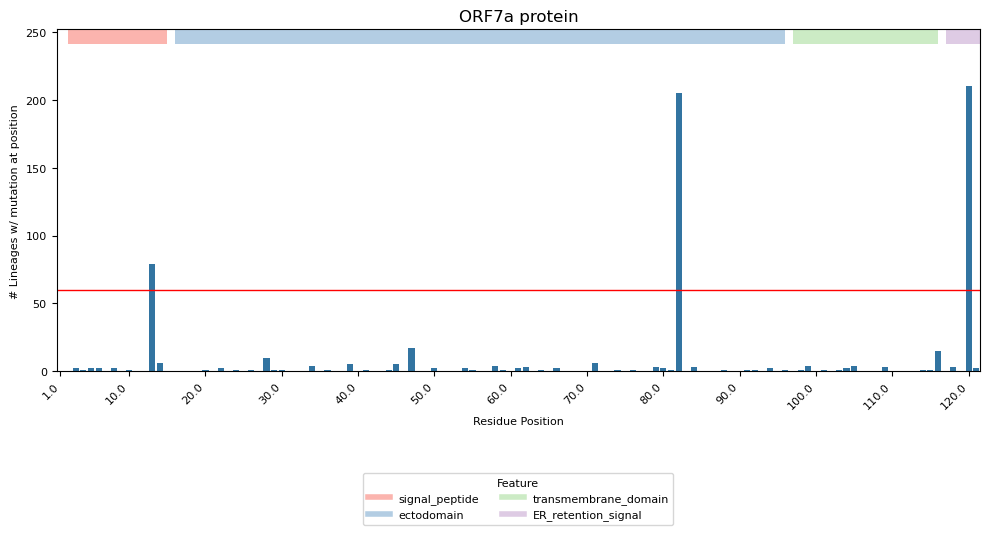

In [34]:
plots["ORF7a protein"]["plot"]

In [46]:
outlier_pos = []
outlier_residues = []
residue_tables = []
product_mut_freq_stats = []
for protein in plots.values():
    outlier_pos.append(protein["outlier_positions"])
    outlier_residues.append(protein["residue_mutations"])
    residue_tables.append(protein["residue_table"])
    product_mut_freq_stats.append({k: protein[k] for k in ["protein", "mean_mutation_freq", "sd_mutation_freq", "max_mutation_freq"]})
outlier_pos_df = pd.concat(outlier_pos)
outlier_residues_df = pd.concat(outlier_residues)
product_mut_freq_stats_df = pd.DataFrame(product_mut_freq_stats)
residue_tables_df = pd.concat(residue_tables)
residue_tables_df_merged = residue_tables_df.merge(spear_data, left_on = ["product", "respos"], right_on = ["product", "AA_coordinate"], how = "left")
outlier_residues_df_merged = outlier_residues_df.merge(spear_data, left_on = ["product", "respos"], right_on = ["product", "AA_coordinate"], how = "left")
outlier_pos_df_merged = outlier_pos_df.merge(spear_data, left_on = ["product", "respos"], right_on = ["product", "AA_coordinate"], how = "left")

In [72]:
product_mut_freq_stats_df.to_csv(f"{analysis_output_dir}/tables/lineage_analysis/product_mutation_frequency.csv", index = False)

In [74]:
outlier_pos_df_merged.loc[outlier_pos_df_merged["product"] == "surface glycoprotein"].domain.value_counts().reset_index().to_csv(f"{analysis_output_dir}/tables/lineage_analysis/spike_outlier_domain_counts.csv", index = False)

In [71]:
residue_tables_df

respos  count               product
0      1.0      0  surface glycoprotein
1      2.0      0  surface glycoprotein
0      3.0     12  surface glycoprotein
2      4.0      0  surface glycoprotein
1      5.0     17  surface glycoprotein
..     ...    ...                   ...
48   117.0      0          ORF8 protein
68   118.0      2          ORF8 protein
69   119.0    206          ORF8 protein
70   120.0      2          ORF8 protein
71   121.0     18          ORF8 protein

[9312 rows x 3 columns]

In [42]:
product_outlier_counts = outlier_pos_df.groupby("product").respos.nunique().reset_index()
product_outlier_counts.to_csv(f"{analysis_output_dir}/tables/lineage_analysis/product_outlier_counts.csv", index = False)

In [51]:
plots["ORF7a protein"]["residue_mutations"]#orf7a_overview_lineage_residue_mutations

respos altres  num_samples        product
0    13.0      T            3  ORF7a protein
1    13.0      V           76  ORF7a protein
2    82.0      A          205  ORF7a protein
3   120.0      I          210  ORF7a protein

In [75]:
plots["membrane glycoprotein"]["residue_mutations"]

respos altres  num_samples                product
0     3.0      G           63  membrane glycoprotein
1     3.0      H          307  membrane glycoprotein
2     3.0      N          483  membrane glycoprotein
3    19.0      E         1789  membrane glycoprotein
4    63.0      T         1791  membrane glycoprotein

In [62]:
membrane_min_hinge_pos = spear_data.loc[(spear_data["product"] == "membrane glycoprotein") & (spear_data["region"] == "hinge_region")].AA_coordinate.min()
membrane_hinge_intravirion_muts = lineages_mutations.loc[(lineages_mutations.description == "membrane glycoprotein") & (lineages_mutations.respos >= 107) & (lineages_mutations.consequence_type.isin(["synonymous_variant", "intergenic_region"]) == False)]
print(f"""
Only {membrane_hinge_intravirion_muts.sample_id.nunique()} lineages contain mutations to hinge region.
one of {membrane_hinge_intravirion_muts.residues.nunique()} mutations in positions above hinge start position ({membrane_min_hinge_pos})
""")


Only 29 lineages contain mutations to hinge region.
one of 14 mutations in positions above hinge start position (107)

